In [30]:
import numpy as np 
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import contextily as ctx
from esda.moran import Moran_Local, Moran
import libpysal
import sys, subprocess
plt.rcParams['font.family'] = 'Times New Roman'

In [32]:
# 1) read data 
df = pd.read_csv('shanghai_house_price_9_with_distances.csv')

lon_col, lat_col = "longitude", "latitude"

In [34]:
# 2) convert to GeoDataFrame
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df[lon_col], df[lat_col]),
    crs="EPSG:4326"  # WGS84
)

# Project to Web Mercator for distance-based weights
gdf = gdf.to_crs(epsg=3857)

D:\anaconda3\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 2544 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


Global Moran's I for unit_price
I = 0.81501
Expected I = -0.00001
z-score = 665.730
p-value (perm, one-tailed) = 0.00100
permutations = 999



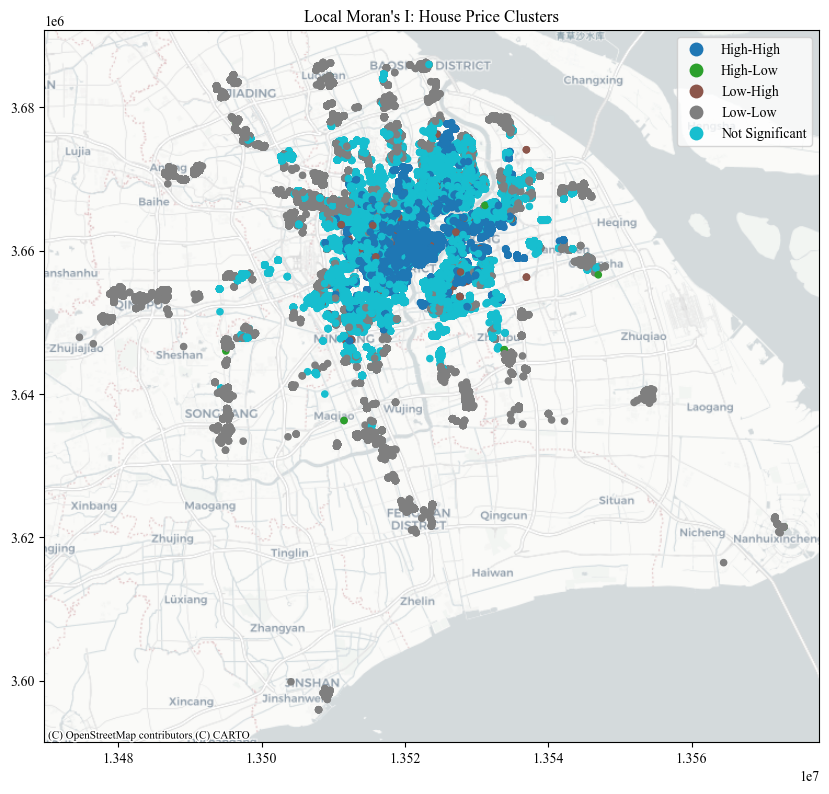

In [38]:
# 3) build spatial weights (k-nearest neighbors, k=8)
coords = [(x,y) for x,y in zip(gdf.geometry.x, gdf.geometry.y)]
w = libpysal.weights.KNN.from_array(coords, k=8)
w.transform = 'R'

# 4 Moran's I
y = gdf['unit_price'].values.astype(float)
moran_g = Moran(y, w, two_tailed=False, permutations=999)  # one-tailed is often used for positive correlation test, two_tailed=False means the default positive correlation right tail

global_txt = (
    f"Global Moran's I for {'unit_price'}\n"
    f"I = {moran_g.I:.5f}\n"
    f"Expected I = {moran_g.EI:.5f}\n"
    f"z-score = {moran_g.z_norm:.3f}\n"
    f"p-value (perm, one-tailed) = {moran_g.p_sim:.5f}\n"
    f"permutations = {moran_g.permutations}\n"
)
print(global_txt)


# 4) Local Moran’s I
y = gdf["unit_price"].values
moran_loc = Moran_Local(y, w)

# 5) add cluster labels
# quadrant coding:
# 1 HH, 2 LH, 3 LL, 4 HL
gdf["local_I"] = moran_loc.Is
gdf["p_sim"] = moran_loc.p_sim
gdf["quadrant"] = moran_loc.q

# filter significant clusters (p < 0.05)
gdf["sig_cluster"] = "Not Significant"
gdf.loc[(gdf["p_sim"] < 0.05) & (gdf["quadrant"] == 1), "sig_cluster"] = "High-High"
gdf.loc[(gdf["p_sim"] < 0.05) & (gdf["quadrant"] == 2), "sig_cluster"] = "Low-High"
gdf.loc[(gdf["p_sim"] < 0.05) & (gdf["quadrant"] == 3), "sig_cluster"] = "Low-Low"
gdf.loc[(gdf["p_sim"] < 0.05) & (gdf["quadrant"] == 4), "sig_cluster"] = "High-Low"

# 6) plot result
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, column="sig_cluster", categorical=True, legend=True, markersize=20)
ctx.add_basemap(ax, crs=gdf.crs, source=ctx.providers.CartoDB.Positron)
plt.title("Local Moran's I: House Price Clusters")
plt.savefig(r"E:\jupyternoteBookWorkPath\erp\house_eco_poi1\spatial_statistics1\lisa_cluster_map.png",
            dpi=300, bbox_inches="tight")
plt.show()